To do:

1. Uitleg features (Jassar)
2. 3 clustering modellen kiezen uitleggen, voor- nadelen (Jordan, Casper, Jassar Ieder neemt 1 model en legt deze uit)
3. Cluster model kiezen en toepassen (Met zn allen als 2 klaar is)
4. Vergelijken labeled en niet labeled 
5. “Dimensionality reduction" toepassen en uitleggen
6. hermodelleren
7. Suggestie appje maken (random liedje uit zelfde cluster)

# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

## Imports

In [3]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from pathlib import Path
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow
import librosa
from scipy.stats import skew, kurtosis

In [4]:
label_genre = pd.read_csv('labels_new.csv')

label_genre.head()

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


In [5]:
#make a list object of unique genres in labels dataframe
genres = list(label_genre['genre'].unique())
genres


['metal',
 'country',
 'hiphop',
 'reggae',
 'classical',
 'jazz',
 'rock',
 'pop',
 'blues',
 'disco']

# Feature engineering

In [6]:
os.listdir('labeled')

['m00002.wav',
 'm00039.wav',
 'm00041.wav',
 'm00072.wav',
 'm00096.wav',
 'm00102.wav',
 'm00112.wav',
 'm00138.wav',
 'm00192.wav',
 'm00206.wav',
 'm00230.wav',
 'm00236.wav',
 'm00248.wav',
 'm00253.wav',
 'm00298.wav',
 'm00313.wav',
 'm00338.wav',
 'm00339.wav',
 'm00351.wav',
 'm00400.wav',
 'm00421.wav',
 'm00429.wav',
 'm00435.wav',
 'm00454.wav',
 'm00477.wav',
 'm00501.wav',
 'm00503.wav',
 'm00513.wav',
 'm00553.wav',
 'm00606.wav',
 'm00623.wav',
 'm00627.wav',
 'm00629.wav',
 'm00633.wav',
 'm00637.wav',
 'm00658.wav',
 'm00671.wav',
 'm00676.wav',
 'm00677.wav',
 'm00678.wav',
 'm00716.wav',
 'm00762.wav',
 'm00772.wav',
 'm00773.wav',
 'm00801.wav',
 'm00821.wav',
 'm00850.wav',
 'm00867.wav',
 'm00895.wav',
 'm00996.wav']

In [7]:
# Define the base directory where the subdirectories "cat" and "dog" are located
base_dir = "labeled"  # Replace with your directory path

# Initialize lists for audio data and labels
audio_data = []
sample_freqs = []
labels = []

# Target length for 5 seconds at a sample rate of 22050 Hz (adjust if different)
target_length = 5 * 22050

# Process each audio file
for label in label_genre['filename']:
    sub_dir = os.path.join(base_dir)
    for file in os.listdir(sub_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(sub_dir, file)
            data, sfreq = lr.load(file_path, sr=None)  # Keep original sample rate

            # Truncate or pad the audio
            if len(data) > target_length:
                # Truncate the data
                data = data[:target_length]
            elif len(data) < target_length:
                # Pad with zeros
                padding = target_length - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)
            labels.append(label)

audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)
labels = np.array(labels)

In [8]:
print(audio_data[:5], labels[:5])

[[-0.01635742 -0.02282715 -0.01467896 ...  0.00747681  0.00817871
   0.00772095]
 [-0.0947876  -0.15338135 -0.1439209  ... -0.18804932 -0.09313965
  -0.0645752 ]
 [ 0.07803345 -0.03765869  0.12664795 ...  0.06295776  0.0484314
   0.02236938]
 [ 0.1060791   0.08496094  0.06210327 ...  0.27041626  0.321167
   0.26272583]
 [-0.03607178 -0.10568237 -0.20123291 ... -0.05239868 -0.0506897
  -0.05014038]] ['m00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav']


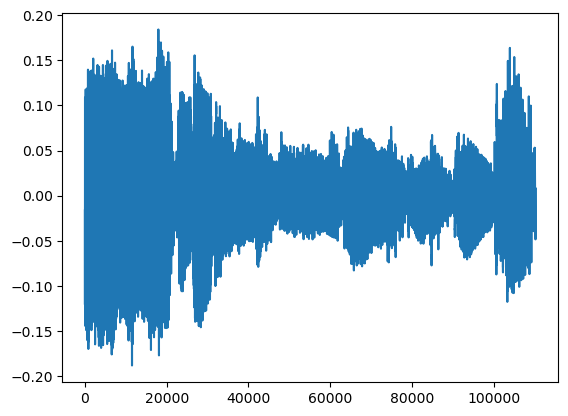

In [9]:
plt.plot(audio_data[0])

In [10]:
# Pick a random audio clip
random_index = np.random.choice(len(audio_data), size=1, replace=False)
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Play the clip
Audio(data=clip, rate=sfreq)

Label m00253.wav


In [11]:
def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:
        win_length = win_length or n_fft

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)



        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)



        # Convert to decibels. Use amplitude_to_db() here.
        deci = amplitude_to_db(spectrogram, ref=np.max)


        # Append the spectrogram to the list
        spectrograms.append(spectrogram)



        # Append spectrogram in decibels to the list
        spectrograms_db.append(deci)



    return spectrograms, spectrograms_db

# Use function
spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)



Label m00513.wav


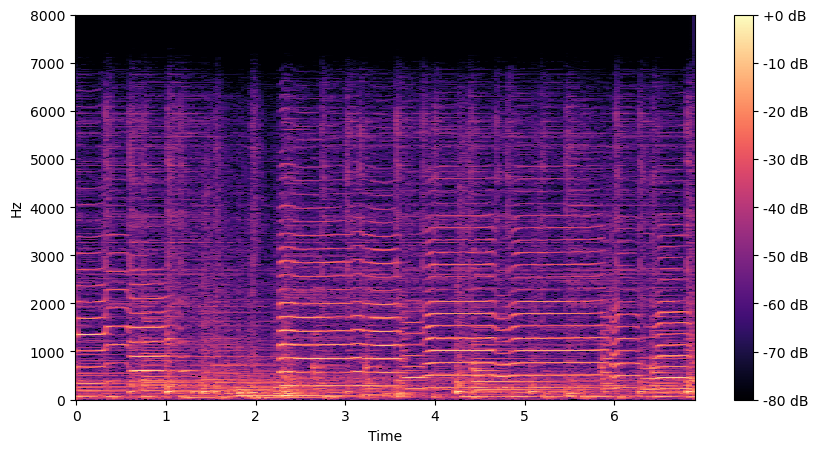

In [12]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)

In [13]:
def calculate_spectral_features(spectrograms):
    """
    Calculate the centroid and bandwidth for each spectrogram in a list.

    Parameters:
    - spectrograms: A list of spectrograms.

    Returns:
    - bandwidths: A list of bandwidths corresponding to each spectrogram
    - centroids: A list of centroids corresponding to each spectrogram
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        bandwidths.append(lr.feature.spectral_bandwidth(S=spectrogram))



        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        centroids.append(lr.feature.spectral_centroid(S=spectrogram))



    return bandwidths, centroids

# Use function
bandwidths, centroids = calculate_spectral_features(spectrograms)

Label m00313.wav


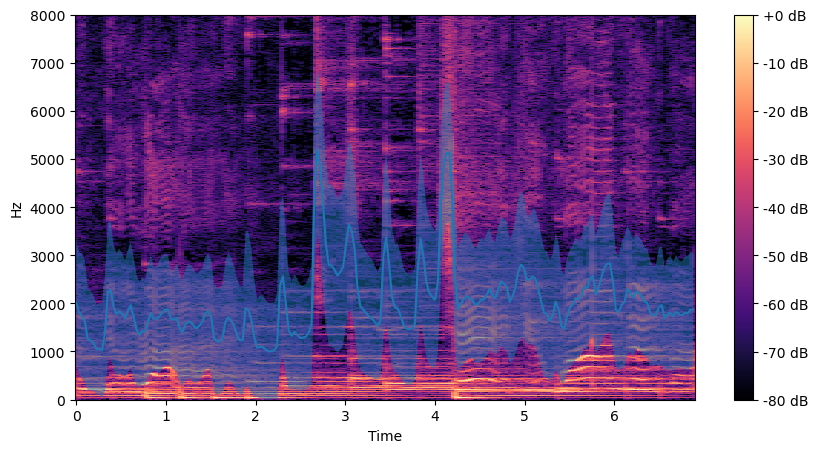

In [14]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]

# Get time index values
times_spec = lr.frames_to_time(range(spectrogram.shape[1]), sr=16000, hop_length=512)

bw = bandwidths[random_index[0]][0]
cent = centroids[random_index[0]][0]

clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.plot(times_spec, cent)
plt.fill_between(times_spec, cent - bw / 2, cent + bw / 2, alpha=.5)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)


## feature creation

In [15]:
# Function to extract spectral features from an audio file
def extract_spectral_features(audio_file, sr=22050):
    try:
        # Load the audio file
        y, sr = librosa.load(audio_file, sr=sr)
        
        # Spectral Features
        features = {}

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_var'] = np.var(mfccs, axis=1)

        # Feature Trajectories
        mfcc_delta = librosa.feature.delta(mfccs)
        features['mfcc_delta_mean'] = np.mean(mfcc_delta, axis=1)
        features['mfcc_delta_var'] = np.var(mfcc_delta, axis=1)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_var'] = np.var(spectral_centroid)
        
        # Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_var'] = np.var(spectral_rolloff)
        
        # Spectral Flux
        spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
        features['spectral_flux_mean'] = np.mean(spectral_flux)
        features['spectral_flux_var'] = np.var(spectral_flux)
        
        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast_mean'] = np.mean(spectral_contrast, axis=1)
        features['spectral_contrast_var'] = np.var(spectral_contrast, axis=1)

        envelope = np.abs(y)
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_var'] = np.var(envelope)

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

        # Time-Domain Features
        features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
        features['rms_var'] = np.var(librosa.feature.rms(y=y))
        features['energy'] = np.sum(y ** 2) / len(y)  # Signal energy
        features['amplitude_mean'] = np.mean(np.abs(y))
        features['amplitude_var'] = np.var(np.abs(y))

        # Temporal Evolution
        dynamic_range = np.max(y) - np.min(y)
        features['dynamic_range'] = dynamic_range

        # Rhythm Features
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        beat_strength = librosa.onset.onset_strength(y=y, sr=sr)
        features['beat_strength_mean'] = np.mean(beat_strength)
        features['beat_strength_var'] = np.var(beat_strength)

        # Rhythmic Regularity
        if len(beat_frames) > 1:
            # Inter-Beat Interval (IBI) Variability
            ibi = np.diff(beat_frames) / sr  # Convert frame difference to seconds
            features['ibi_var'] = np.var(ibi)
            features['ibi_mean'] = np.mean(ibi)

        # Harmonic Features
        # Key and Scale Estimation
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_var'] = np.var(chroma, axis=1)
        
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)
        features['tonnetz_var'] = np.var(tonnetz, axis=1)

        # Harmonic-to-Percussive Ratio
        harmonic, percussive = librosa.effects.hpss(y)
        hpr = np.mean(harmonic) / (np.mean(percussive) + 1e-6)
        features['hpr'] = hpr

        # Genre-Specific Features
        # Harmonic and Percussive Energy
        features['harmonic_energy'] = np.sum(harmonic ** 2)
        features['percussive_energy'] = np.sum(percussive ** 2)

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_var'] = np.var(zcr)

        # Onset Autocorrelation (Rhythmic Regularity)
        onset_acf = librosa.autocorrelate(librosa.onset.onset_strength(y=y, sr=sr), max_size=len(y)//2)
        features['onset_acf_mean'] = np.mean(onset_acf)
        features['onset_acf_var'] = np.var(onset_acf)

        # Statistics (Skewness and Kurtosis)
        features['skewness'] = skew(y)
        features['kurtosis'] = kurtosis(y)


        
        return features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None




# Function to process all files in a folder
def process_audio_folder(folder_path, output_csv="audio_features.csv"):
    feature_list = []
    file_names = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file is a valid audio file
        if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_name}")
            
            # Extract features
            features = extract_spectral_features(file_path)
            
            if features:
                # Flatten features and add file name
                flat_features = {}
                for key, value in features.items():
                    if isinstance(value, np.ndarray):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    elif isinstance(value, list):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    else:
                        flat_features[key] = value
                
                flat_features['file_name'] = file_name
                feature_list.append(flat_features)

    # Convert to DataFrame
    df = pd.DataFrame(feature_list)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")



if __name__ == "__main__":
    # Path to your folder containing audio files
    folder_path = "labeled"
    
    # Process folder and save features to CSV
    process_audio_folder(folder_path, output_csv="audio_features_labeled.csv")

if __name__ == "__main__":
    # Path to your folder containing audio files
    folder_path = "unlabeled"
    
    # Process folder and save features to CSV
    process_audio_folder(folder_path, output_csv="audio_features_unlabeled.csv")


Processing file: m00002.wav
Processing file: m00039.wav
Processing file: m00041.wav
Processing file: m00072.wav
Processing file: m00096.wav
Processing file: m00102.wav
Processing file: m00112.wav
Processing file: m00138.wav
Processing file: m00192.wav
Processing file: m00206.wav
Processing file: m00230.wav
Processing file: m00236.wav
Processing file: m00248.wav
Processing file: m00253.wav
Processing file: m00298.wav
Processing file: m00313.wav
Processing file: m00338.wav
Processing file: m00339.wav
Processing file: m00351.wav
Processing file: m00400.wav
Processing file: m00421.wav
Processing file: m00429.wav
Processing file: m00435.wav
Processing file: m00454.wav
Processing file: m00477.wav
Processing file: m00501.wav
Processing file: m00503.wav
Processing file: m00513.wav
Processing file: m00553.wav
Processing file: m00606.wav
Processing file: m00623.wav
Processing file: m00627.wav
Processing file: m00629.wav
Processing file: m00633.wav
Processing file: m00637.wav
Processing file: m00

In [16]:
audio_features_labeled = pd.read_csv('audio_features_labeled.csv')
audio_features_unlabeled = pd.read_csv('audio_features_unlabeled.csv')

In [17]:
audio_features_unlabeled

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-82.511116,97.341720,-34.367928,71.408500,-3.292029,17.375372,-9.026282,16.017792,-19.010939,12.084585,...,0.474129,5015.80270,4307.202600,0.120116,0.001477,1039.467131,5.273896e+05,0.050494,1.502084,m00003.wav
1,-1.913298,72.686160,-32.791992,63.605473,-18.556350,25.870161,-13.859100,18.078884,-11.946615,19.672184,...,-0.078451,13640.32800,7645.469000,0.178108,0.001759,865.396302,2.375552e+05,-0.060755,0.636350,m00012.wav
2,-287.603700,101.758170,-35.345410,41.280160,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,...,1.883158,659.46704,27.311030,0.123423,0.002215,909.275098,3.408593e+05,0.002769,4.551729,m00013.wav
3,-120.147490,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119440,23.654900,-14.630774,13.370976,...,0.205245,3793.30030,1411.787000,0.126073,0.002020,1161.553835,5.831156e+05,-0.049281,0.961996,m00043.wav
4,-437.604400,170.931530,7.419581,-3.083473,0.789382,-11.128749,-12.522780,-6.907836,-5.858702,-8.461237,...,0.280722,279.69208,9.179426,0.052088,0.000365,506.792468,1.151717e+05,0.032408,4.131841,m00044.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-246.158650,149.428670,-41.988865,11.606256,-10.289647,-4.019358,-7.136855,-10.135562,-9.420322,-7.171843,...,0.275623,762.61774,132.529590,0.091590,0.000850,853.576092,2.621164e+05,0.053047,3.764138,m00971.wav
101,-8.573005,54.295788,20.964115,13.100406,9.715855,6.022176,10.730787,6.106817,0.696941,5.003989,...,0.048683,27315.84000,11874.389000,0.161797,0.007166,1704.611611,1.507474e+06,0.040381,0.691344,m00973.wav
102,-56.153060,36.448500,11.979400,-6.415675,3.782166,5.288356,3.395965,4.261923,7.989973,5.857594,...,-0.053873,18644.25400,20602.850000,0.167480,0.017958,2845.677413,4.674188e+06,-0.068967,3.400681,m00988.wav
103,-406.846680,163.081340,-2.372812,32.416626,7.946261,9.632712,-5.456720,9.490358,-3.060804,10.187205,...,0.486376,207.61370,1.958432,0.044217,0.000346,492.731899,8.025172e+04,-0.043439,1.066043,m00991.wav


In [18]:
display(audio_features_labeled.head())
display(audio_features_unlabeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-298.75613,112.07628,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,...,0.304814,2037.1526,39.70027,0.051224,0.000629,672.615954,1.643258e+05,0.088488,2.617145,m00002.wav
1,-169.15335,110.46000,-8.576200,43.884247,0.274970,26.637417,-14.368152,13.034431,-11.149249,8.130109,...,0.902208,6367.0254,3609.18820,0.072150,0.002673,2154.544729,2.526802e+06,0.106281,3.148987,m00039.wav
2,-18.84539,71.32566,-3.766897,-1.408727,0.705463,-1.058955,-1.054825,-0.247421,0.625723,0.427043,...,-0.625686,13829.2340,7554.96900,0.152857,0.004726,1287.389960,8.480074e+05,-0.037692,1.653724,m00041.wav
3,-69.63065,83.07227,-16.599928,0.118371,7.420607,0.770008,1.337478,4.695799,-1.416824,3.319435,...,0.445260,6298.0127,5382.89000,0.120217,0.001512,1514.820424,1.071666e+06,0.040828,3.730454,m00072.wav
4,-91.98377,87.64010,-2.066796,34.278150,-18.124570,19.345660,-14.665754,17.112076,-15.336202,17.028183,...,0.864006,8329.7780,16146.33900,0.115834,0.002543,2690.703374,4.645377e+06,0.071066,3.297007,m00096.wav


,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-82.511116,97.341720,-34.367928,71.408500,-3.292029,17.375372,-9.026282,16.017792,-19.010939,12.084585,...,0.474129,5015.80270,4307.202600,0.120116,0.001477,1039.467131,527389.554370,0.050494,1.502084,m00003.wav
1,-1.913298,72.686160,-32.791992,63.605473,-18.556350,25.870161,-13.859100,18.078884,-11.946615,19.672184,...,-0.078451,13640.32800,7645.469000,0.178108,0.001759,865.396302,237555.198666,-0.060755,0.636350,m00012.wav
2,-287.603700,101.758170,-35.345410,41.280160,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,...,1.883158,659.46704,27.311030,0.123423,0.002215,909.275098,340859.348454,0.002769,4.551729,m00013.wav
3,-120.147490,91.317215,-38.845890,75.008400,-3.813260,22.665588,-8.119440,23.654900,-14.630774,13.370976,...,0.205245,3793.30030,1411.787000,0.126073,0.002020,1161.553835,583115.610309,-0.049281,0.961996,m00043.wav
4,-437.604400,170.931530,7.419581,-3.083473,0.789382,-11.128749,-12.522780,-6.907836,-5.858702,-8.461237,...,0.280722,279.69208,9.179426,0.052088,0.000365,506.792468,115171.708944,0.032408,4.131841,m00044.wav


# Unsupervised Learning

In [19]:
# from pycaret.clustering import ClusteringExperiment